In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize, root_scalar
from datetime import datetime

In [2]:
# SABR implied volatility approximation (Hagan et al.)
def sabr_vol(F, K, T, alpha, beta, rho, nu):
    if F == K:
        # ATM formula
        term1 = ((1 - beta)**2 / 24) * (alpha**2) / (F**(2 - 2*beta))

        term2 = (rho * beta * nu * alpha) / (4 * F**(1 - beta))
        term3 = (nu**2 * (2 - 3 * rho**2)) / 24
        vol_atm = alpha / (F**(1 - beta)) * (1 + (term1 + term2 + term3) * T)
        return vol_atm
    else:
        # Non-ATM formula
        z = (nu / alpha) * (F * K)**((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho))
        FK_beta = (F * K)**((1 - beta) / 2)
        term1 = 1 + ((1 - beta)**2 / 24) * ((np.log(F / K))**2 + ((1 - beta)**4 / 1920) * (np.log(F / K))**4)**4
        term2 = ((1 - beta)**2 / 24) * (alpha**2) / (F*K)**(1 - beta)
        term3 = (rho * beta * nu * alpha) / (4 * (F*K)**((1 - beta)/2))
        term4 = (2 - 3*rho**2) * nu**2 / 24
        vol = (alpha / (FK_beta * term1)) * (z / x_z) * (1 + (term2 + term3 + term4) * T)
        return vol

# Q0
As warm-up, implement the SABR formula for implied volatility and replicate the graph in the below screenshot.

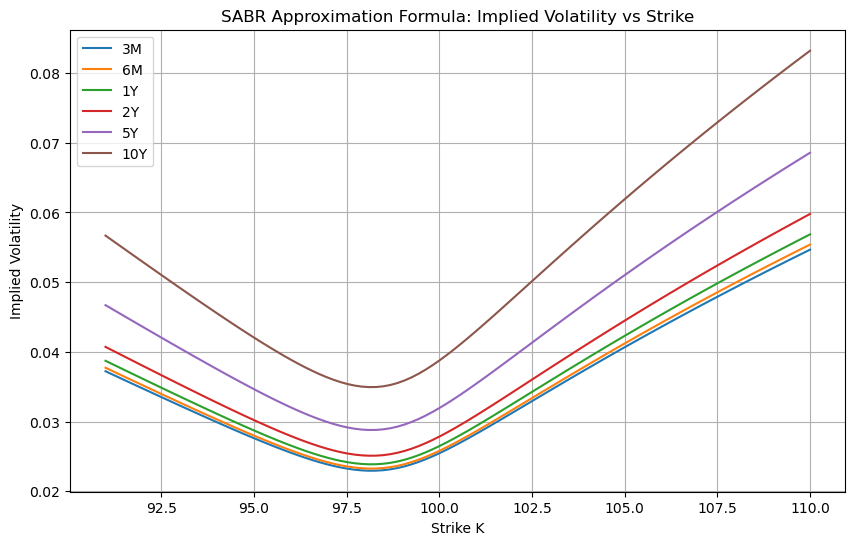

In [3]:
# Parameters
F = 100  # Forward
alpha = 0.10  # Initial volatility s0
beta = 0.7
rho = 0.5
nu = 1.0

# Define strikes
K = np.linspace(91, 110, 100)

# Define maturities
T_list = [0.25, 0.5, 1, 2, 5, 10]  # 3M, 6M, 1Y, 2Y, 5Y, 10Y

# Plot
plt.figure(figsize=(10, 6))

for T in T_list:
    vol = [sabr_vol(F, k, T, alpha, beta, rho, nu) for k in K]
    plt.plot(K, vol, label=f'{int(T*12)}M' if T < 1 else f'{int(T)}Y')

plt.title('SABR Approximation Formula: Implied Volatility vs Strike')
plt.xlabel('Strike K')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Q1
For every maturity in the table, use the SABR model (with correlation $\rho$ parameter set to 0), to construct all 5 strikes involved in the market quotes. For every maturity, list these strikes and their corresponding implied volatilities (make a nice table). In a separate table, list the calibrated SABR parameters for every maturity.

In [4]:
#create data set
data = {
    'Tenor': ['ON', '1W', '2W', '1M', '2M', '3M', '6M', '1Y'],
    'Maturity Date': ['2025-04-11', '2025-04-17', '2025-04-24', '2025-05-12',
                      '2025-06-10', '2025-07-10', '2025-10-10', '2026-04-10'],
    'ATM Vol (%)': [10.99, 9.4, 8.68, 9.55, 10.14, 10.62, 11.52, 12.25],
    '25d RR (%)': [-0.5, -0.6, -0.75, -1.0, -1.25, -1.52, -1.62, -1.75],
    '25d Mkt Strangle (%)': [0.15, 0.15, 0.15, 0.17, 0.23, 0.25, 0.35, 0.4]
}

df0 = pd.DataFrame(data)
df0

,Tenor,Maturity Date,ATM Vol (%),25d RR (%),25d Mkt Strangle (%)
0,ON,2025-04-11,10.99,-0.50,0.15
1,1W,2025-04-17,9.40,-0.60,0.15
2,2W,2025-04-24,8.68,-0.75,0.15
3,1M,2025-05-12,9.55,-1.00,0.17
4,2M,2025-06-10,10.14,-1.25,0.23
5,3M,2025-07-10,10.62,-1.52,0.25
6,6M,2025-10-10,11.52,-1.62,0.35
7,1Y,2026-04-10,12.25,-1.75,0.40


In [5]:
df=df0.copy()

In [6]:
df['Market Strangle Vol (%)'] = df['25d Mkt Strangle (%)']+df['ATM Vol (%)']

In [7]:
#constant
x = 1.15
# rd = 0.01
# rf = 0.02
rf=0.01
rd=0.02
t0 = datetime.strptime('2025-04-10', '%Y-%m-%d')

In [8]:
df

,Tenor,Maturity Date,ATM Vol (%),25d RR (%),25d Mkt Strangle (%),Market Strangle Vol (%)
0,ON,2025-04-11,10.99,-0.50,0.15,11.14
1,1W,2025-04-17,9.40,-0.60,0.15,9.55
2,2W,2025-04-24,8.68,-0.75,0.15,8.83
3,1M,2025-05-12,9.55,-1.00,0.17,9.72
4,2M,2025-06-10,10.14,-1.25,0.23,10.37
5,3M,2025-07-10,10.62,-1.52,0.25,10.87
6,6M,2025-10-10,11.52,-1.62,0.35,11.87
7,1Y,2026-04-10,12.25,-1.75,0.40,12.65


In [9]:
df['Delta_T']=df['Maturity Date'].apply(lambda x: (datetime.strptime(x, '%Y-%m-%d')-t0).days/365).round(4)
# 1. Convert % to decimal
df['ATM Vol'] = df['ATM Vol (%)'] / 100
df['25d RR'] = df['25d RR (%)'] / 100
df['Market Strangle Vol'] = df['Market Strangle Vol (%)'] / 100

In [10]:
df

,Tenor,Maturity Date,ATM Vol (%),25d RR (%),25d Mkt Strangle (%),Market Strangle Vol (%),Delta_T,ATM Vol,25d RR,Market Strangle Vol
0,ON,2025-04-11,10.99,-0.50,0.15,11.14,0.0027,0.1099,-0.0050,0.1114
1,1W,2025-04-17,9.40,-0.60,0.15,9.55,0.0192,0.0940,-0.0060,0.0955
2,2W,2025-04-24,8.68,-0.75,0.15,8.83,0.0384,0.0868,-0.0075,0.0883
3,1M,2025-05-12,9.55,-1.00,0.17,9.72,0.0877,0.0955,-0.0100,0.0972
4,2M,2025-06-10,10.14,-1.25,0.23,10.37,0.1671,0.1014,-0.0125,0.1037
5,3M,2025-07-10,10.62,-1.52,0.25,10.87,0.2493,0.1062,-0.0152,0.1087
6,6M,2025-10-10,11.52,-1.62,0.35,11.87,0.5014,0.1152,-0.0162,0.1187
7,1Y,2026-04-10,12.25,-1.75,0.40,12.65,1.0000,0.1225,-0.0175,0.1265


In [11]:
df['Fwd']=x*np.exp((rd-rf)*df['Delta_T'])

In [12]:
df['Fwd']

0    1.150031
1    1.150221
2    1.150442
3    1.151009
4    1.151923
5    1.152871
6    1.155781
7    1.161558
Name: Fwd, dtype: float64

In [13]:
df=df[['Tenor','Delta_T','Fwd','ATM Vol','25d RR','Market Strangle Vol']]

In [14]:
df

,Tenor,Delta_T,Fwd,ATM Vol,25d RR,Market Strangle Vol
0,ON,0.0027,1.150031,0.1099,-0.0050,0.1114
1,1W,0.0192,1.150221,0.0940,-0.0060,0.0955
2,2W,0.0384,1.150442,0.0868,-0.0075,0.0883
3,1M,0.0877,1.151009,0.0955,-0.0100,0.0972
4,2M,0.1671,1.151923,0.1014,-0.0125,0.1037
5,3M,0.2493,1.152871,0.1062,-0.0152,0.1087
6,6M,0.5014,1.155781,0.1152,-0.0162,0.1187
7,1Y,1.0000,1.161558,0.1225,-0.0175,0.1265


It follows from the Black-Scholes formula:

$$
\begin{aligned}
V_d(t) &= P_d(t, T_d) N \left[ F(t, T_d)\Phi(d_+) - K \Phi(d_-) \right] \\\\
       &= N \left[ X(t) P_f(t, T_d) \Phi(d_+) - K P_d(t, T_d) \Phi(d_-) \right]
\end{aligned}
$$

where $\Phi$ is the cumulative Normal distribution function;  
$X(t)$ can be extracted from $S(t)$ (see Lecture 1); and

$$
d_{\pm} = \frac{\ln \left( \frac{F(t, T_d)}{K} \right) \pm \frac{1}{2} \sigma^2 (T - t)}{\sigma \sqrt{T - t}}
       = \frac{\ln \left( \frac{X(t)}{K} \right) + \ln \left( \frac{P_f(t, T_d)}{P_d(t, T_d)} \right) \pm \frac{1}{2} \sigma^2 (T - t)}{\sigma \sqrt{T - t}}.
$$
The above gives the price in domestic currency XXX.  
The price in foreign currency YYY is therefore:

$$
V_f(t) = X(t)^{-1} V_d(t).
$$
Note that if we sell $N$ units of YYY for $M$ units of XXX (i.e. a **put** on YYY and a **call** on XXX),  the correct formula can be found by put-call parity:

$$
\begin{aligned}
V_d(t) = P_d(t, T_d) N \left[ -F(t, T_d) \Phi(-d_+) + K \Phi(-d_-) \right].
\end{aligned}
$$


In [15]:
# Black-Scholes pricing formula for European options
def bs_price(F, K, T, sigma, option_type='call'):
    d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return np.exp(-rd*T) * (F * norm.cdf(d1) - K * norm.cdf(d2))/x
    else:
        return np.exp(-rd*T) * (K * norm.cdf(-d2) - F * norm.cdf(-d1))/x


In [16]:
# Non-premium-adjusted Call Delta
def delta_call(K, F, T, alpha, beta, rho, nu, rf, delta_target):
    sigma = sabr_vol(F, K, T, alpha, beta, rho, nu)
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta - delta_target

# Non-premium-adjusted Put Delta
def delta_put(K, F, T, alpha, beta, rho, nu, rf, delta_target):
    sigma = sabr_vol(F, K, T, alpha, beta, rho, nu)
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1) - 1  # put delta = N(d1) - 1
    return delta + delta_target  # because put delta is negative


In [17]:
def delta_call_fixed_sigma(K, F, T, sigma, rf, delta_target):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)  # Black delta (call)
    return delta - delta_target

def delta_put_fixed_sigma(K, F, T, sigma, rf, delta_target):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1) - 1  # Black delta (put)
    return delta + delta_target  # because it's negative


In [18]:
#find K_atm for all tenors
K_atm_25_list=[]
for index, row in df.iterrows():
  K_atm=row['Fwd']*np.exp(-0.5*row['ATM Vol']**2*row['Delta_T'])
  K_atm_25_list.append(K_atm)
df['K_atm_25']=K_atm_25_list
print(K_atm_25_list)

[1.1500122989552415, 1.150123257164888, 1.1502752769222317, 1.1505487694853767, 1.1509341127497823, 1.151250893648695, 1.1519416300690286, 1.1528749940066785]


/var/folders/03/d5gbj72s2gx1f3jr9b8jy3dh0000gn/T/ipykernel_33737/1560146328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['K_atm_25']=K_atm_25_list


In [19]:
from logging import root
#find Ks
Ksc_list=[]
Ksp_list=[]
for index, row in df.iterrows():
  Ksc=root_scalar(delta_call_fixed_sigma, bracket=[0.5*row['Fwd'], 2*row['Fwd']], args=(row['Fwd'], row['Delta_T'], row['Market Strangle Vol'], rf, 0.25)).root
  Ksp=root_scalar(delta_put_fixed_sigma, bracket=[0.5*row['Fwd'], 2*row['Fwd']], args=(row['Fwd'], row['Delta_T'], row['Market Strangle Vol'], rf, 0.25)).root
  Ksc_list.append(Ksc)
  Ksp_list.append(Ksp)
df['Ksc_25']=Ksc_list
df['Ksp_25']=Ksp_list


/var/folders/03/d5gbj72s2gx1f3jr9b8jy3dh0000gn/T/ipykernel_33737/1351671023.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ksc_25']=Ksc_list
/var/folders/03/d5gbj72s2gx1f3jr9b8jy3dh0000gn/T/ipykernel_33737/1351671023.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ksp_25']=Ksp_list


In [20]:
df

,Tenor,Delta_T,Fwd,ATM Vol,25d RR,Market Strangle Vol,K_atm_25,Ksc_25,Ksp_25
0,ON,0.0027,1.150031,0.1099,-0.0050,0.1114,1.150012,1.154549,1.145569
1,1W,0.0192,1.150221,0.0940,-0.0060,0.0955,1.150123,1.160635,1.140100
2,2W,0.0384,1.150442,0.0868,-0.0075,0.0883,1.150275,1.164121,1.137263
3,1M,0.0877,1.151009,0.0955,-0.0100,0.0972,1.150549,1.174061,1.129345
4,2M,0.1671,1.151923,0.1014,-0.0125,0.1037,1.150934,1.186400,1.120460
5,3M,0.2493,1.152871,0.1062,-0.0152,0.1087,1.151251,1.197618,1.113068
6,6M,0.5014,1.155781,0.1152,-0.0162,0.1187,1.151942,1.227525,1.095945
7,1Y,1.0000,1.161558,0.1225,-0.0175,0.1265,1.152875,1.275178,1.075128


In [21]:
from scipy.optimize import least_squares
delta = 0.25
results = []
k_results = []

for index, row in df.iterrows():
    F = row['Fwd']
    T = row['Delta_T']
    sigma_atm = df['ATM Vol'].iloc[index]
    RR = df['25d RR'].iloc[index]
    sigma_s = df['Market Strangle Vol'].iloc[index]

    # K_atm = F * np.exp(-0.5 * sigma_atm**2 * T)
    K_atm = F * np.exp(0.5 * sigma_atm**2 * T)

    def objective_adjusted(params):
        alpha, beta, nu, rho = params

        # alpha, beta, nu = params
        # rho=0
        try:
            sigma_atm_sabr = sabr_vol(F, K_atm, T, alpha, beta, rho, nu)

            K_C = root_scalar(delta_call, bracket=[0.5 * F, 2 * F], args=(F, T, alpha, beta, rho, nu, rf, delta)).root
            K_P = root_scalar(delta_put, bracket=[0.5 * F, 2 * F], args=(F, T, alpha, beta, rho, nu, rf, delta)).root

            sigma_C = sabr_vol(F, K_C, T, alpha, beta, rho, nu)
            sigma_P = sabr_vol(F, K_P, T, alpha, beta, rho, nu)

            K_Cs = root_scalar(delta_call_fixed_sigma, bracket=[0.5 * F, 2 * F], args=(F, T, sigma_s, rf, delta)).root
            K_Ps = root_scalar(delta_put_fixed_sigma, bracket=[0.5 * F, 2 * F], args=(F, T, sigma_s, rf, delta)).root

            sigma_Cs = sabr_vol(F, K_Cs, T, alpha, beta, rho, nu)
            sigma_Ps = sabr_vol(F, K_Ps, T, alpha, beta, rho, nu)

            V_Cs = bs_price(F, K_Cs, T, sigma_Cs, 'call')
            V_Ps = bs_price(F, K_Ps, T, sigma_Ps, 'put')
            V_model = V_Cs + V_Ps

            V_market = bs_price(F, K_Cs, T, sigma_s, 'call') + bs_price(F, K_Ps, T, sigma_s, 'put')

            err1 = (sigma_atm_sabr - sigma_atm) ** 2
            err2 = (sigma_C - sigma_P - RR) ** 2
            err3 = (V_model - V_market) ** 2

            return err1 + err2 + err3
        except:
            return 1e6

    initial_guess = [0.2, 0.5, 0.5, 0.0]  # [alpha, beta, nu, rho]
    bounds = ([0, 0, 0, 0],[float('inf'),1,1,float('inf')])
    #res_adjusted = minimize(objective_adjusted, initial_guess, bounds=bounds, method='L-BFGS-B')
    res_adjusted = least_squares(objective_adjusted, initial_guess, bounds=bounds)
    alpha_adj, beta_adj, nu_adj, rho_adj = res_adjusted.x

    # from scipy.optimize import minimize

    # initial_guess = [0.2, 0.5, 0.5]  # [alpha, beta, nu]
    # bounds = [(0, None), (0, 1), (0, 1)]  # alpha >= 0, 0 <= beta <= 1, -1 <= nu <= 1

    # res_adjusted = minimize(objective_adjusted, initial_guess, bounds=bounds, method='L-BFGS-B')

    # alpha_adj, beta_adj, nu_adj = res_adjusted.x
    # rho_adj = 0.0

    results.append({
        'Tenor': row['Tenor'],
        'alpha': alpha_adj,
        'beta': beta_adj,
        'nu': nu_adj,
        'rho': rho_adj,
        'objective': res_adjusted.fun
    })

    K_call = root_scalar(delta_call, bracket=[0.5 * F, 2 * F], args=(F, T, alpha_adj, beta_adj, rho_adj, nu_adj, rf, delta)).root
    K_put = root_scalar(delta_put, bracket=[0.5 * F, 2 * F], args=(F, T, alpha_adj, beta_adj, rho_adj, nu_adj, rf, delta)).root
    K_call_s = root_scalar(delta_call_fixed_sigma, bracket=[0.5 * F, 2 * F], args=(F, T, sigma_s, rf, delta)).root
    K_put_s = root_scalar(delta_put_fixed_sigma, bracket=[0.5 * F, 2 * F], args=(F, T, sigma_s, rf, delta)).root

    vol_atm = sabr_vol(F, K_atm, T, alpha_adj, beta_adj, rho_adj, nu_adj)
    vol_call = sabr_vol(F, K_call, T, alpha_adj, beta_adj, rho_adj, nu_adj)
    vol_put = sabr_vol(F, K_put, T, alpha_adj, beta_adj, rho_adj, nu_adj)
    vol_call_s = sabr_vol(F, K_call_s, T, alpha_adj, beta_adj, rho_adj, nu_adj)
    vol_put_s = sabr_vol(F, K_put_s, T, alpha_adj, beta_adj, rho_adj, nu_adj)

    k_results.append({
        'Tenor': row['Tenor'],
        'K_atm': K_atm,
        'vol_atm': vol_atm,
        'K_call': K_call,
        'vol_call': vol_call,
        'K_put': K_put,
        'vol_put': vol_put,
        'K_call_s': K_call_s,
        'vol_call_s': vol_call_s,
        'K_put_s': K_put_s,
        'vol_put_s': vol_put_s
    })


In [22]:
results_df=pd.DataFrame(results)
k_results_df=pd.DataFrame(k_results)

In [23]:
results_df

,Tenor,alpha,beta,nu,rho,objective
0,ON,0.119473,0.494361,0.499988,9.997655e-11,[2.4885361220821924e-05]
1,1W,0.102176,0.493089,0.499921,9.991727e-11,[3.25180828223795e-05]
2,2W,0.094733,0.410769,0.588422,1.924921e-11,[4.8022012601523376e-05]
3,1M,0.103867,0.414220,0.579725,1.490784e-10,[8.007145412591913e-05]
4,2M,0.108998,0.492970,0.499321,9.949859e-11,[0.00012314681633300489]
5,3M,0.115740,0.408484,0.574638,6.254017e-08,[0.0001697718493401167]
6,6M,0.125855,0.390097,0.484522,3.750223e-11,[0.00015666101245603392]
7,1Y,0.133532,0.385689,0.465795,3.885074e-11,[0.00013969637036000351]


In [24]:

k_results_df

,Tenor,K_atm,vol_atm,K_call,vol_call,K_put,vol_put,K_call_s,vol_call_s,K_put_s,vol_put_s
0,ON,1.150050,0.111326,1.154542,0.111222,1.145567,0.111441,1.154549,0.111222,1.145569,0.111441
1,1W,1.150318,0.095215,1.160583,0.095036,1.140104,0.095464,1.160635,0.095035,1.140100,0.095464
2,2W,1.150608,0.087318,1.163934,0.087112,1.137351,0.087703,1.164121,0.087111,1.137263,0.087706
3,1M,1.151469,0.095878,1.173661,0.095566,1.129469,0.096628,1.174061,0.095565,1.129345,0.096634
4,2M,1.152913,0.101787,1.185604,0.101410,1.120713,0.102827,1.186400,0.101409,1.120460,0.102838
5,3M,1.154492,0.107091,1.196740,0.106683,1.113004,0.108887,1.197618,0.106689,1.113068,0.108883
6,6M,1.159632,0.116246,1.225405,0.115477,1.095707,0.119219,1.227525,0.115486,1.095945,0.119203
7,1Y,1.170306,0.123757,1.271703,0.123086,1.073754,0.128839,1.275178,0.123132,1.075128,0.128733


In [25]:
df['ATM Vol']

0    0.1099
1    0.0940
2    0.0868
3    0.0955
4    0.1014
5    0.1062
6    0.1152
7    0.1225
Name: ATM Vol, dtype: float64

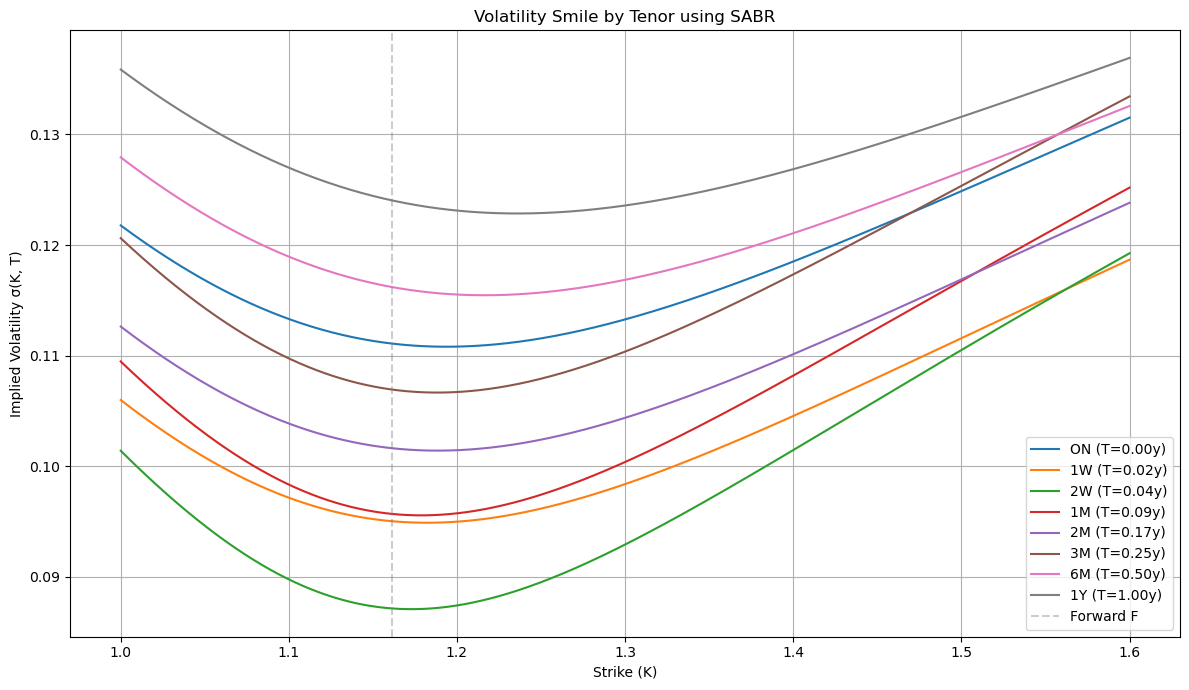

In [26]:

plt.figure(figsize=(12, 7))
K_grid = np.linspace(0.8, 1.2, 100) 

for i in range(len(df)):
    F = df['Fwd'].iloc[i]
    T = df['Delta_T'].iloc[i]
    alpha = results_df['alpha'].iloc[i]
    beta = results_df['beta'].iloc[i]
    nu = results_df['nu'].iloc[i]
    rho = results_df['rho'].iloc[i]

    K_values = np.linspace(1.00, 1.60, 1000) 
    sigma_values = [sabr_vol(F, K, T, alpha, beta, rho, nu) for K in K_values]

    tenor_label = df['Tenor'].iloc[i]
    plt.plot(K_values, sigma_values, label=f'{tenor_label} (T={T:.2f}y)')


plt.title("Volatility Smile by Tenor using SABR")
plt.xlabel("Strike (K)")
plt.ylabel("Implied Volatility σ(K, T)")
plt.axvline(x=F, color='gray', linestyle='--', label='Forward F', alpha=0.4)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Q2
For the 3-month (3M) maturity, work out the strikes that correspond to deltas of 10% and 90%. On this range of strikes, draw a smooth graph of the function $\sigma(K)$

In [27]:
type(results)

list

In [28]:
results[5]


{'Tenor': '3M',
 'alpha': 0.1157403462533621,
 'beta': 0.40848383630513385,
 'nu': 0.5746379196528165,
 'rho': 6.254016578291243e-08,
 'objective': array([0.00016977])}

In [29]:
alpha_val = results[5]['alpha']
beta_val = results[5]['beta']
nu_val = results[5]['nu']
rho_val=results[5]['rho']
k_atm_value=k_results[5]['K_atm']
T_val=df['Delta_T'].iloc[5]
F_val=df['Fwd'].iloc[5]
sigma_s_3w=df['Market Strangle Vol'].iloc[5]

In [30]:
delta_10=0.10
delta_90=0.9


In [31]:

from scipy.optimize import fsolve

Kc_90 = fsolve(delta_call, x0=F_val * 1.1, args=(F_val, T_val, alpha_val, beta_val, rho_val, nu_val, rf, 0.90))[0]
Kc_10 = fsolve(delta_call, x0=F_val * 0.9, args=(F_val, T_val, alpha_val, beta_val, rho_val, nu_val, rf, 0.10))[0]

print(f"Kc_90 (call, Δ=0.90): {Kc_90:.6f}")
print(f"Kc_10 (call, Δ=0.10): {Kc_10:.6f}")
sigma_c_90 = sabr_vol(F_val, Kc_90, T_val, alpha_val, beta_val, rho_val, nu_val)
print(f"SABR_Kc_90 (call, Δ=0.90): {sigma_c_90:.6f}")
sigma_c_10 = sabr_vol(F_val, Kc_10, T_val, alpha_val, beta_val, rho_val, nu_val)
print(f"SABR_Kc_10 (call, Δ=0.10): {sigma_c_10:.6f}")


Kc_90 (call, Δ=0.90): 1.074963
Kc_10 (call, Δ=0.10): 1.236702
SABR_Kc_90 (call, Δ=0.90): 0.111781
SABR_Kc_10 (call, Δ=0.10): 0.107449


In [32]:
Ksc_90 = fsolve(delta_call_fixed_sigma, x0=F_val * 1.1, args=(F_val, T_val, sigma_s_3w, rf, 0.90))[0]
Ksc_10 = fsolve(delta_call_fixed_sigma, x0=F_val * 0.9, args=(F_val, T_val, sigma_s_3w, rf, 0.10))[0]

print(f"Ksc_90 (call, sigma_s): {Ksc_90:.6f}")
print(f"Ksc_10 (call, sigma_s): {Ksc_10:.6f}")


Ksc_90 (call, sigma_s): 0.608214
Ksc_10 (call, sigma_s): 1.895260


/var/folders/03/d5gbj72s2gx1f3jr9b8jy3dh0000gn/T/ipykernel_33737/4178083996.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Ksc_90 = fsolve(delta_call_fixed_sigma, x0=F_val * 1.1, args=(F_val, T_val, sigma_s_3w, rf, 0.90))[0]
/var/folders/03/d5gbj72s2gx1f3jr9b8jy3dh0000gn/T/ipykernel_33737/4178083996.py:2: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Ksc_10 = fsolve(delta_call_fixed_sigma, x0=F_val * 0.9, args=(F_val, T_val, sigma_s_3w, rf, 0.10))[0]


In [33]:
K_list=[Kc_10,Ksc_10,
        Kc_90,Ksc_90,
        k_atm_value]

In [34]:
sigma_atm=k_results_df['vol_atm'].iloc[5]

sigma_c_10=sabr_vol(F_val, Kc_10, T_val, alpha_val, beta_val, rho_val, nu_val)

sigma_sc_10=sabr_vol(F_val, Ksc_10, T_val, alpha_val, beta_val, rho_val, nu_val)


sigma_c_90=sabr_vol(F_val, Kc_90, T_val, alpha_val, beta_val, rho_val, nu_val)

sigma_sc_90=sabr_vol(F_val, Ksc_90, T_val, alpha_val, beta_val, rho_val, nu_val)


In [35]:
sigma_list=[sigma_c_10,sigma_sc_10,
           sigma_c_90,sigma_sc_90,
            sigma_atm]

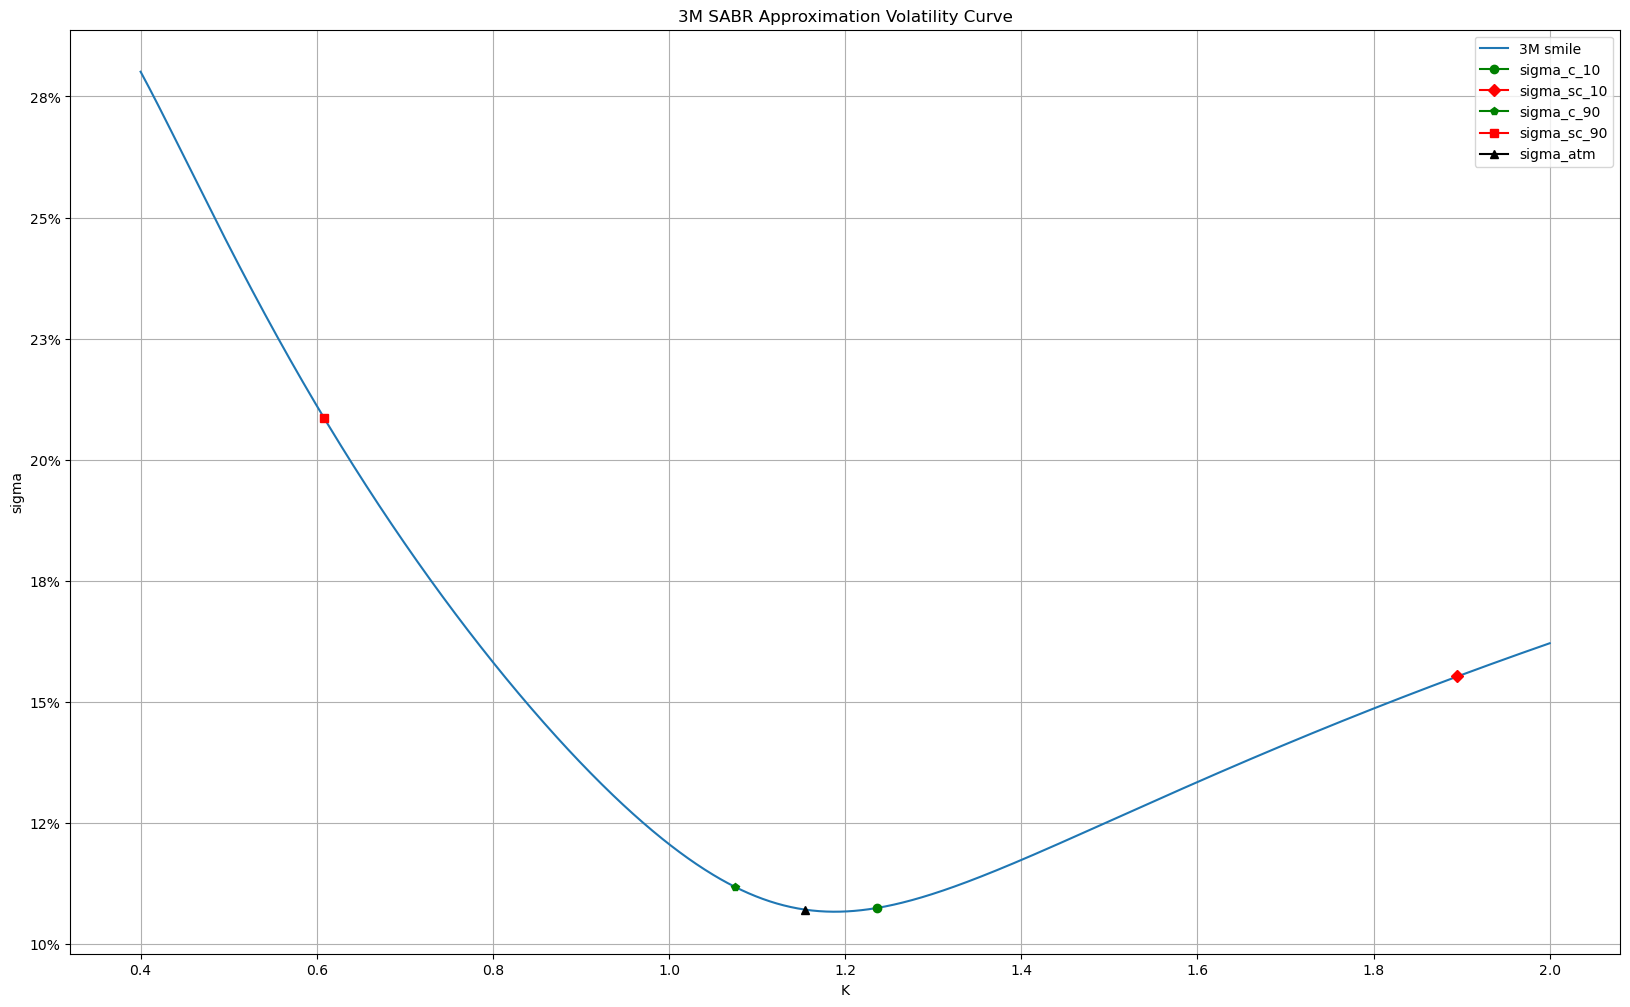

In [36]:
markers=['o','D','p','s','^']
colors=['green','red','green','red','black']
names = [
    'sigma_c_10', 'sigma_sc_10', 
    'sigma_c_90', 'sigma_sc_90', 
   
    'sigma_atm'
]
K_values_Q2=np.linspace(0.4,2,1000)
plt.figure(figsize=(20,12))
SABR_values = [
    sabr_vol(F_val, K, T_val, alpha_val, beta_val, rho_val, nu_val)
    for K in K_values_Q2
]
plt.plot(K_values_Q2, SABR_values, label=f"3M smile")
for i in range(len(K_list)):
    plt.plot(K_list[i],sigma_list[i],marker=markers[i],color=colors[i],label=names[i])

def percentage(x, pos):
    return '{:.0f}%'.format(x * 100)

plt.xlabel("K")
plt.ylabel("sigma")
plt.legend()
plt.grid()
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage))
plt.title("3M SABR Approximation Volatility Curve")

plt.show()

# Q3
List the implied volatility when the strike is equal to the forward rate, for all maturities in the table.

In [37]:
df_Q3 = pd.concat([
    df[['Tenor', 'Delta_T', 'Fwd']].reset_index(drop=True),
    results_df[['alpha', 'beta', 'nu', 'rho']].reset_index(drop=True)
], axis=1)

In [38]:
df_Q3

,Tenor,Delta_T,Fwd,alpha,beta,nu,rho
0,ON,0.0027,1.150031,0.119473,0.494361,0.499988,9.997655e-11
1,1W,0.0192,1.150221,0.102176,0.493089,0.499921,9.991727e-11
2,2W,0.0384,1.150442,0.094733,0.410769,0.588422,1.924921e-11
3,1M,0.0877,1.151009,0.103867,0.414220,0.579725,1.490784e-10
4,2M,0.1671,1.151923,0.108998,0.492970,0.499321,9.949859e-11
5,3M,0.2493,1.152871,0.115740,0.408484,0.574638,6.254017e-08
6,6M,0.5014,1.155781,0.125855,0.390097,0.484522,3.750223e-11
7,1Y,1.0000,1.161558,0.133532,0.385689,0.465795,3.885074e-11


In [39]:
#sabr_vol(F, K, T, alpha, beta, rho, nu)
sabr_kF=[]
for index, row in df_Q3.iterrows():
    sabr=sabr_vol(row['Fwd'], row['Fwd'], row['Delta_T'], row['alpha'], row['beta'], row['rho'], row['nu'])
    sabr_kF.append(sabr)
print(sabr_kF)


[0.1113261776869206, 0.0952166960349591, 0.08732167998090747, 0.0958888502551927, 0.10180926353791066, 0.10713403541307008, 0.11636029610310114, 0.12402573370882002]


In [40]:
result_Q3=pd.DataFrame(sabr_kF,columns=['Implied Volatility'])

In [41]:
result_Q3 = pd.concat([
    df_Q3[['Tenor', 'Fwd']].reset_index(drop=True),
    result_Q3.reset_index(drop=True)
], axis=1)

In [42]:
result_Q3

,Tenor,Fwd,Implied Volatility
0,ON,1.150031,0.111326
1,1W,1.150221,0.095217
2,2W,1.150442,0.087322
3,1M,1.151009,0.095889
4,2M,1.151923,0.101809
5,3M,1.152871,0.107134
6,6M,1.155781,0.116360
7,1Y,1.161558,0.124026


# Q4
We want to use the event-weighting scheme of Lecture 3 to
take into account week-end effects (ignore holidays and other
events); assume that volatilities are set to 0 on weekends. Given
this, and ignoring the smile, use the ATM-forward volatilities
in Q3 to construct implied volatilities for every day (including
weekend days) out to the 6-month maturity point (should be
around 180 separate dates). Draw a graph of these volatilities
as a function of option maturity. As in the lecture notes, assume
that the function q is piecewise flat.

set ω=1 on weekdays and ω=0 on weekends


In [43]:
pillar=df0['Maturity Date']

pillar_dates=list[pillar]
print(pillar_dates)


list[0    2025-04-11
1    2025-04-17
2    2025-04-24
3    2025-05-12
4    2025-06-10
5    2025-07-10
6    2025-10-10
7    2026-04-10
Name: Maturity Date, dtype: object]


In [44]:
pillar = df0['Maturity Date']  
pillar_dates = list(pillar)    
print(type(pillar_dates))
today = pd.to_datetime('10/04/2025', dayfirst=True)

<class 'list'>


In [45]:
pillar_dates = pd.to_datetime(pillar_dates, format='mixed', dayfirst=True, errors='coerce')
print(pillar_dates)

DatetimeIndex(['2025-04-11', '2025-04-17', '2025-04-24', '2025-05-12',
               '2025-06-10', '2025-07-10', '2025-10-10', '2026-04-10'],
              dtype='datetime64[ns]', freq=None)


In [46]:
day_arr = np.array([(d - today).days for d in pillar_dates])
day_arr

array([  1,   7,  14,  32,  61,  91, 183, 365])

In [47]:
pillar_dates = pd.to_datetime(pillar_dates, format='mixed', dayfirst=True, errors='coerce')
print(pillar_dates)



DatetimeIndex(['2025-04-11', '2025-04-17', '2025-04-24', '2025-05-12',
               '2025-06-10', '2025-07-10', '2025-10-10', '2026-04-10'],
              dtype='datetime64[ns]', freq=None)


In [48]:
from datetime import datetime
date = datetime.strptime('2025-04-10', '%Y-%m-%d')
weekday = date.strftime('%A')
print(weekday)

Thursday


In [49]:
w_arr = []
while len(w_arr) < 183:
    w_arr.extend([1, 1, 0, 0, 1, 1, 1])
w_arr = w_arr[:183]

In [50]:
w_arr

[1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1]

In [51]:
pillar_vols = df['ATM Vol'].values


In [52]:
q_values = []
for i in range(1,7):
    start = day_arr[i-1]
    end = day_arr[i]
    count = sum(w_arr[start:end])
    q = np.sqrt((pillar_vols[i]**2*end - pillar_vols[i-1]**2*start)/count)
    q_values.append(q)
q_values

[0.1115504258172061,
 0.09341023498525203,
 0.12462230939924038,
 0.12636899107281782,
 0.13469468505408133,
 0.1457614427131475]

In [53]:
temp = [[q_values[i-1]]*(day_arr[i]-day_arr[i-1]) for i in range(1,7)]
q_arr = [pillar_vols[0]]
for sublist in temp:
    q_arr.extend(sublist)

In [54]:
integrand = np.array(q_arr)**2*np.array(w_arr)

In [55]:
print(f"len(q_arr): {len(q_arr)}")
print(f"len(w): {len(w_arr
                     )}")

len(q_arr): 183
len(w): 183


In [56]:
sigma_arr = np.sqrt(np.cumsum(integrand)/np.arange(1,len(integrand)+1))
sigma_arr

array([0.1099    , 0.11072829, 0.09040927, 0.07829672, 0.08598256,
       0.09074553, 0.094     , 0.09392648, 0.09386926, 0.0890522 ,
       0.08490794, 0.08564871, 0.08627054, 0.0868    , 0.08981836,
       0.09237857, 0.08962038, 0.08709535, 0.08946376, 0.09154295,
       0.09338424, 0.09502719, 0.09650285, 0.09447098, 0.09256228,
       0.09399777, 0.09530766, 0.09650806, 0.09761241, 0.09863198,
       0.0970281 , 0.0955    , 0.09658049, 0.0975865 , 0.09852561,
       0.09940441, 0.1002286 , 0.09890102, 0.09762482, 0.09844576,
       0.09922036, 0.09995249, 0.1006456 , 0.10130279, 0.10017088,
       0.09907608, 0.09973458, 0.10036158, 0.10095934, 0.10152987,
       0.10207502, 0.10108877, 0.10013056, 0.10067862, 0.10120394,
       0.10170793, 0.10219188, 0.10265698, 0.10178329, 0.10093153,
       0.1014    , 0.10202326, 0.10262313, 0.10320092, 0.10375787,
       0.10296882, 0.10219751, 0.1027499 , 0.10328345, 0.10379913,
       0.10429784, 0.10478042, 0.10406028, 0.10335477, 0.10383

In [57]:
len(day_arr)

8

In [58]:
len(pillar_vols[:-1])

7

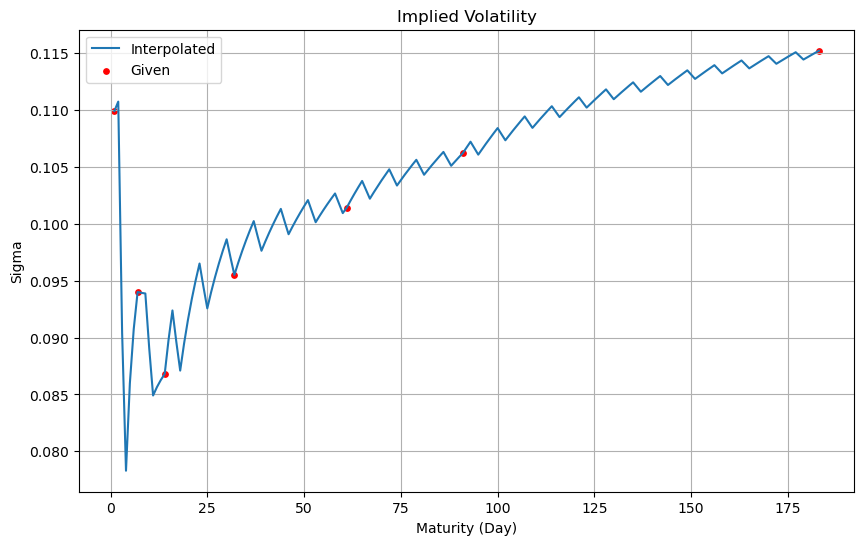

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 184), sigma_arr,label = 'Interpolated')
plt.scatter(day_arr[:-1], pillar_vols[:-1], color='red', marker='o',label='Given',s=15)
plt.xlabel('Maturity (Day)')
plt.ylabel('Sigma')
plt.title('Implied Volatility')
plt.legend()
plt.grid()
plt.show()